In [221]:
import csv
import cv2
from PIL import Image
import numpy as np
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint
from models import *
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model
import sklearn


np.random.seed(33)  # for reproducibility
path_model='./MODEL'
path_log = './log'
nb_epoch=2
batch_size=32
steer_threshold = 0.02
p_drop_low = 0.9 # probability of dropping the sample whose steer is lower than steer_threshold
hyperparams_name = 'myCNN'
save_file = os.path.join(path_log, '{}.loss.png'.format(hyperparams_name))

load_pre_model = True 
CAMERA = True
FLIP = True # If you open this swich, pls remember set steps_one_epoch by factor correctly, OR set factor=0
factor = (1/2 +1)
resized_shape = 64 #resized to 64x64

/Users/kudou/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [222]:
def load_samples():
	samples=[]
	with open('./data/driving_log.csv') as csvfile:
		reader = csv.reader(csvfile)
		for line in reader:
 			samples.append(line)
	return np.array(sklearn.utils.shuffle(samples))

def gen_data(samples, batch_size):

	def get_pic_and_label(source_path):

		filename = source_path.split('/')[-1]

		current_path='./data/IMG/'+ filename

		img_pil = Image.open(current_path)
		w, h = img_pil.size
		img_cropped = img_pil.crop((0,50,w,h-25))
		img_resized = img_cropped.resize((resized_shape,resized_shape), Image.ANTIALIAS) # resized default to 64x64

		image = np.asarray(img_resized)
		return image
		
	#offset = 0 
	#print('number of samples is:', len(lines))	
	samples = samples[ 0 : samples.shape[0] // batch_size * batch_size]
	num_samples = samples.shape[0]

	#train_samples = samples[ :-int(len_samples*0.1) ]
	#valid_samples = samples[ -int(len_samples*0.1): ]

	while True:
				
		#for offset in range(0, num_samples, batch_size):
			
			batch_X = np.zeros((batch_size, resized_shape, resized_shape, 3))
			batch_y = np.zeros(batch_size)
			#batch_lines = samples[ offset : offset + batch_size]
                                
			for idx in range(batch_size):
				sample_flag = True
				while sample_flag:
					sample = samples[np.random.randint(num_samples)]
					if np.abs(float(sample[3])) < steer_threshold and np.random.random() < p_drop_low:
						sample_flag = True
					else:
						sample_flag = False
                    
				# Data Augmentation by right or left camera       
				camera = np.random.choice(['center','left', 'right'])

				if camera == 'left':
					camera_path=sample[1]
					bias=0.22
				elif camera=='right':
					camera_path=sample[2]
					bias=-0.22
				elif camera == 'center':
					camera_path=sample[0]
					bias=0

				image  = get_pic_and_label(camera_path)
                
				measurement = float(sample[3]) + bias
				# Data Augmentation by Flip
				if FLIP == True:
					flip_prob = np.random.random()
					if flip_prob > 0.5:
						image = np.fliplr(image)
						measurement = -measurement
						#pass

				batch_X[idx] = image
				batch_y[idx] = measurement

			yield (batch_X, batch_y)

In [223]:
print("loading data...")
samples = load_samples()
len_samples = samples.shape[0]
print(samples.shape)

loading data...
(8036, 7)


In [224]:
train_samples = samples[ :-int(len_samples*0.1) ]
valid_samples = samples[ -int(len_samples*0.1): ]
print('The number of all original (without augmented data) samples is: {} \n,\
    the number of original train_samples is : {} \n \
    the number of original valid_samples is : {} \n'
    .format(len_samples, train_samples.shape[0],valid_samples.shape[0]))

train_generator = gen_data(train_samples, batch_size)
valid_generator = gen_data(valid_samples, batch_size)

print('initial train_samples len is', train_samples.shape[0])
train_samples = train_samples[ 0 : train_samples.shape[0] // batch_size * batch_size]
num_samples = train_samples.shape[0]
print('After train_samples len is', num_samples)
print('steps of on epoch is:', num_samples/batch_size)

The number of all original (without augmented data) samples is: 8036 
,    the number of original train_samples is : 7233 
     the number of original valid_samples is : 803 

initial train_samples len is 7233
After train_samples len is 7232
steps of on epoch is: 226.0


In [225]:
iters = 100

In [226]:
from tqdm import tqdm
steer_data=[]
ii=0
for x,y in tqdm(train_generator):
    steer_data.extend(list(y))
    ii += 1
    if ii == iters:
        break 




0it [00:00, ?it/s]


1it [00:00,  6.22it/s]


2it [00:00,  6.49it/s]


3it [00:00,  6.58it/s]


4it [00:00,  6.61it/s]


5it [00:00,  6.75it/s]


6it [00:00,  6.86it/s]


7it [00:01,  6.47it/s]


8it [00:01,  6.24it/s]


9it [00:01,  6.01it/s]


10it [00:01,  5.95it/s]


11it [00:01,  6.20it/s]


12it [00:01,  6.38it/s]


13it [00:02,  6.52it/s]


14it [00:02,  6.55it/s]


15it [00:02,  6.72it/s]


16it [00:02,  6.78it/s]


17it [00:02,  6.86it/s]


18it [00:02,  6.98it/s]


19it [00:02,  6.99it/s]


20it [00:03,  7.01it/s]


21it [00:03,  7.00it/s]


22it [00:03,  6.88it/s]


23it [00:03,  6.87it/s]


24it [00:03,  7.00it/s]


25it [00:03,  7.08it/s]


26it [00:03,  7.24it/s]


27it [00:03,  7.23it/s]


28it [00:04,  7.17it/s]


29it [00:04,  7.27it/s]


30it [00:04,  7.35it/s]


31it [00:04,  7.34it/s]


32it [00:04,  7.38it/s]


33it [00:04,  7.55it/s]


34it [00:04,  7.57it/s]


35it [00:05,  7.34it/s]


36it [00:05,  7.34it/s]


37it [00:05,  7.43it/s]


38it [00:05,  7.44it/s]

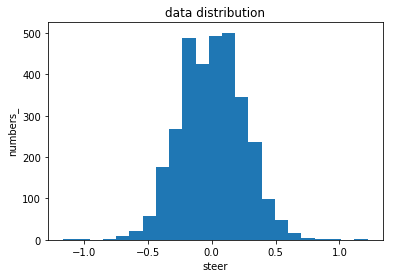

In [228]:
from utils.visualizaiton import *
def plot_distribution(data_label):
	plt.figure()
	plt.hist(data_label, bins=23)
	plt.title('data distribution')
	plt.ylabel('numbers_')
	plt.xlabel('steer')
	#plt.xticks(np.arange(0, 0.1, 0.01))
    
%matplotlib inline
plot_distribution(steer_data[:])